Ahmed Asfour/22040301084 Notebook
Popularity Baseline + Text Classification Pipeline (Mutual Information FS + TruncatedSVD DR + 2 Base Models)
Amaç 
Kod üç ana hedefi yerine getirir:

Popularity Baseline Modeli oluşturmak

Ürünleri yorum sayısı ve ortalama rating’e göre sıralar.

En popüler ürünleri çıkarır.

Outline gereksinimlerine uygun bir sınıflandırma hattı kurmak

Mutual Information ile Feature Selection

TruncatedSVD (250 komponent) ile Dimension Reduction

İki temel model eğitilir: Logistic **Regression ve Naive Bayes**

Aşamalar arasında performans karşılaştırması yapılır.

Model değerlendirme çıktıları ve grafikler üretmek

Accuracy, F1, Precision, Recall tabloları

Confusion Matrix

ROC Curve

SVD explained variance grafiği

Stage karşılaştırma trend grafikleri

Girdi (Input)

final_clean_data.csv
İçermesi gereken kolonlar:

asin/product_title/text/rating

Çıktılar (Outputs / outputs/)

Bu notebook aşağıdaki dosyaları üretir:

ahmed_popularity_top.csv

-En popüler ürünlerin listesi (yorum sayısı + ortalama rating’e göre)
ahmed_base_models_comparison.csv

-Tüm aşamalar için model karşılaştırma tablosu (Accuracy, F1, Precision, Recall)

-Tüm ekip üyelerinin çıktılarının birleştiği final karşılaştırma tablosu
team_models_comparison.csv





In [1]:

import pandas as pd
import numpy as np
import os, re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from IPython.display import display


1) Veri Yükleme
Bu bölümde final_clean_data.csv dosyası okunur.  
Bu dosya tüm ekibin ortak temizlenmiş ve birleştirilmiş veri setidir.
 


In [2]:
df = pd.read_csv("final_clean_data.csv")
print("Shape:", df.shape)
display(df.head())


Shape: (633693, 12)


rating                                      title  \
0     5.0  Such a lovely scent but not overpowering.   
1     4.0     Works great but smells a little weird.   
2     1.0                          Synthetic feeling   
3     5.0                                         A+   
4     4.0                               Pretty Color   

                                                text        asin  \
0  This spray is really nice. It smells really go...  B00YQ6X8EO   
1  This product does what I need it to do, I just...  B081TJ8YS3   
2                                     Felt synthetic  B09JS339BZ   
3                                            Love it  B08BZ63GMJ   
4  The polish was quiet thick and did not apply s...  B00R8DXL44   

                        user_id                timestamp  \
0  AGKHLEW2SOWHNMFQIJGBECAF7INQ  2020-05-05 14:08:48.923   
1  AGKHLEW2SOWHNMFQIJGBECAF7INQ  2020-05-04 18:10:55.070   
2  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ  2022-01-28 18:13:50.220   
3  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ  2020-12-30 10:02:43.534   
4  AGMJ3EMDVL6OWBJF7CA5RGJLXN5A  2020-08-27 22:30:08.138   

                                       product_title main_category  \
0  Herbivore - Natural Sea Mist Texturizing Salt ...    All Beauty   
1  All Natural Vegan Dry Shampoo Powder - Eco Fri...    All Beauty   
2  muaowig Ombre Body Wave Bundles 1B Grey Human ...    All Beauty   
3  Yinhua Electric Nail Drill Kit Portable Profes...    All Beauty   
4           China Glaze Nail Polish, Wanderlust 1381    All Beauty   

   average_rating  review_length  year  \
0             4.3            300  2020   
1             4.0            235  2020   
2             1.0             14  2022   
3             3.5              7  2020   
4             3.8            125  2020   

                                          clean_text  
0  spray really nice smells really good goes real...  
1  product need wish odorless soft coconut smell ...  
2                                     felt synthetic  
3                                               love  
4  polish quiet thick apply smoothly let dry over...

2) Popularity Baseline (Popülerlik Temelli Basit Model)
We compute:
Hesaplananlar:
- Her ürün için toplam yorum sayısı (review_count)
- Her ürün için ortalama rating (avg_rating)

Ürünler yorum sayısı ve ortalama rating’e göre sıralanır.

outputs/ahmed_popularity_top.csv


Saved: outputs/ahmed_popularity_top.csv


asin  review_count  avg_rating
47951  B07C533XCW          1500    4.465333
14932  B00R1TAN7I          1362    4.029369
90288  B08L5KN7X4          1328    4.012048
22341  B019GBG0IE          1319    3.536012
18292  B0107QYW14          1105    3.931222
19068  B012Q9NGE4           856    4.046729
71771  B07ZJKVVLW           831    4.275572
40637  B074KD4PX2           777    3.881596
4475   B005BZQHEC           772    4.747409
82009  B08B1PR9C7           749    4.603471

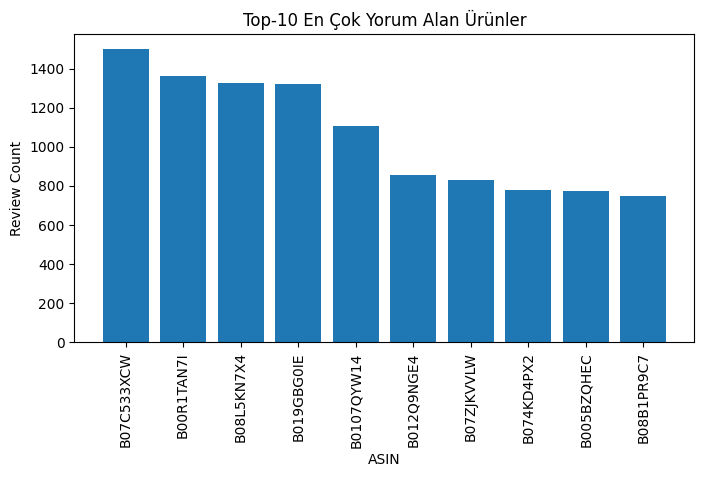

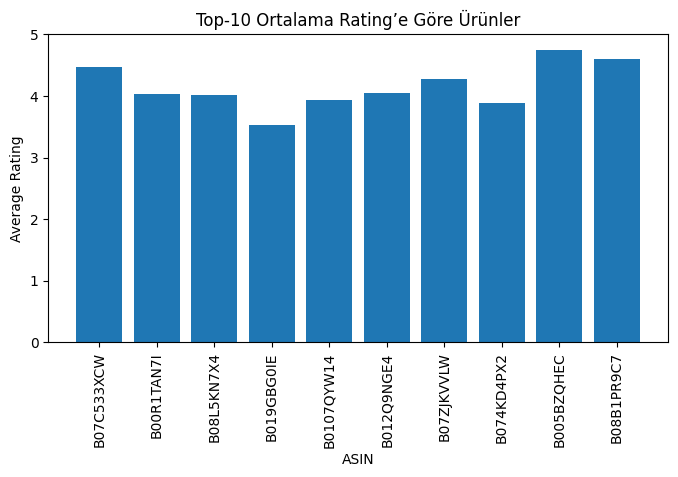

In [ ]:
popularity = (
    df.groupby("asin")
      .agg(review_count=("rating","count"), avg_rating=("rating","mean"))
      .reset_index()
      .sort_values(["review_count","avg_rating"], ascending=False)
)

os.makedirs("outputs", exist_ok=True)
popularity.head(20).to_csv("outputs/ahmed_popularity_top.csv", index=False)
print("Saved: outputs/ahmed_popularity_top.csv")
display(popularity.head(10))

top_pop = popularity.head(10)

plt.figure(figsize=(8,4))
plt.bar(top_pop["asin"], top_pop["review_count"])
plt.title("Top-10 En Çok Yorum Alan Ürünler")
plt.xlabel("ASIN")
plt.ylabel("Review Count")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(top_pop["asin"], top_pop["avg_rating"])
plt.title("Top-10 Ortalama Rating’e Göre Ürünler")
plt.xlabel("ASIN")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(0,5)
plt.show()



3)Text cleaning
Light cleaning to stabilize TF-IDF.


In [6]:
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text_clean"] = df["text"].fillna("").apply(clean_text)


4) TF-IDF Özelliklerinin Üretilmesi
Yorum metinleri TF-IDF kullanılarak sayısal vektörlere dönüştürülür.


Parametreler:
- max_features=12000  
- ngram_range=(1,2)  
- min_df=3


Amaç:


Klasik ML modelleri için kullanılabilir yüksek boyutlu metin özellikleri oluşturmak.


In [7]:
tfidf = TfidfVectorizer(stop_words="english", max_features=12000, ngram_range=(1,2), min_df=3)
X_tfidf = tfidf.fit_transform(df["text_clean"])
print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (633693, 12000)


5) Hedef Değişkeninin Oluşturulması (Target Label)
   Rating değeri ikili sınıfa dönüştürülür:


rating >= 4 → 1 (Pozitif)


rating < 4 → 0 (Negatif)


Amaç:
Sınıflandırma modellerinin çalışması için hedef değişken oluşturmak.



In [9]:
df["label"] = (df["rating"] >= 4).astype(int)
y = df["label"].values


6) Train-Test Ayrımı


  Veri:


  %80 eğitim  
  %20 test



olarak stratify=y ile dengeli biçimde ayrılır.  


Amaç: 


Model performansını adil ve kararlı şekilde değerlendirmek.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)


7) Aşama 1 – FS/DR Öncesi Basit Modeller

Bu aşamada iki basit model eğitilir:

-Logistic Regression
-Multinomial Naive Bayes

Hesaplanan metrikler:


-Accuracy  
-F1  
-Precision  
-Recall  

Amaç:


Herhangi bir özellik seçimi veya boyut indirgeme olmadan temel performansı görmek.


In [11]:
results = []

def eval_stage(Xtr, Xte, stage_name, use_nb=True):
    models = [("LogReg", LogisticRegression(max_iter=1000))]
    if use_nb:
        models.append(("NaiveBayes", MultinomialNB()))

    for name, model in models:
        model.fit(Xtr, y_train)
        pred = model.predict(Xte)
        results.append({
            "stage": stage_name,
            "model": name,
            "accuracy": accuracy_score(y_test, pred),
            "f1": f1_score(y_test, pred),
            "precision": precision_score(y_test, pred),
            "recall": recall_score(y_test, pred)
        })

eval_stage(X_train, X_test, "Before_FS_DR", use_nb=True)


8) Aşama 2 – Feature Selection (Mutual Information)


Bu aşamada, bir FS yöntemi kullanıcağım:
-Diğer üyeler Chi-Square kullanırken  
-Ben Mutual Information kullanıcağım

En iyi 2000 özellik seçilir.

Amaç: 


Etki değeri düşük kelimeleri filtreleyerek modellerin öğrenmesini iyileştirmek.


In [12]:
fs = SelectKBest(mutual_info_classif, k=2000)
X_train_fs = fs.fit_transform(X_train, y_train)
X_test_fs  = fs.transform(X_test)

print("After MI FS:", X_train_fs.shape)

eval_stage(X_train_fs, X_test_fs, "After_FS(MI)", use_nb=True)


c:\Users\isc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\isc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\isc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\isc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but r

After MI FS: (506954, 2000)


9) Aşama 3 – Dimension Reduction (TruncatedSVD)


Feature Selection sonrası, özellikler 250 bileşene indirgenir.


Not:  


SVD negatif değer ürettiği için Naive Bayes bu aşamada kullanılmaz.  
Bu yüzden sadece Logistic Regression değerlendirilir.

Amaç: 


Özellikleri sıkıştırıp modellerin genelleme performansını artırmak ve aşırı boyutu azaltmak.


In [13]:
svd = TruncatedSVD(n_components=250, random_state=42)
X_train_dr = svd.fit_transform(X_train_fs)
X_test_dr  = svd.transform(X_test_fs)

print("After SVD:", X_train_dr.shape)
print("Explained variance ratio sum:", svd.explained_variance_ratio_.sum())

eval_stage(X_train_dr, X_test_dr, "After_FS_DR(SVD)", use_nb=False)


After SVD: (506954, 250)
Explained variance ratio sum: 0.49777391903071366


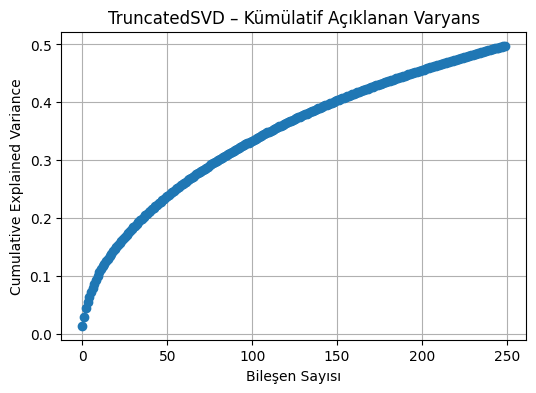

In [14]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker="o")
plt.title("TruncatedSVD – Kümülatif Açıklanan Varyans")
plt.xlabel("Bileşen Sayısı")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


10)Aşama Sonuçlarının Karşılaştırılması


Tüm aşamaların sonuçları tek bir tabloda toplanır:

1. Before_FS_DR

2. After_FS(MI) 

3. After_FS_DR(SVD) 



Tabloda şunlar bulunur:


-Accuracy  
-F1  
-Precision  
-Recall 


Çıktı:


outputs/ahmed_base_models_comparison.csv

In [15]:
results_df = pd.DataFrame(results)
display(results_df)

results_df.to_csv("outputs/ahmed_base_models_comparison.csv", index=False)
print("Saved: outputs/ahmed_base_models_comparison.csv")


stage       model  accuracy        f1  precision    recall
0      Before_FS_DR      LogReg  0.891494  0.924973   0.907311  0.943336
1      Before_FS_DR  NaiveBayes  0.868533  0.911564   0.871409  0.955599
2      After_FS(MI)      LogReg  0.875792  0.914765   0.890822  0.940031
3      After_FS(MI)  NaiveBayes  0.836554  0.894385   0.825329  0.976052
4  After_FS_DR(SVD)      LogReg  0.850172  0.898107   0.867223  0.931273

Saved: outputs/ahmed_base_models_comparison.csv


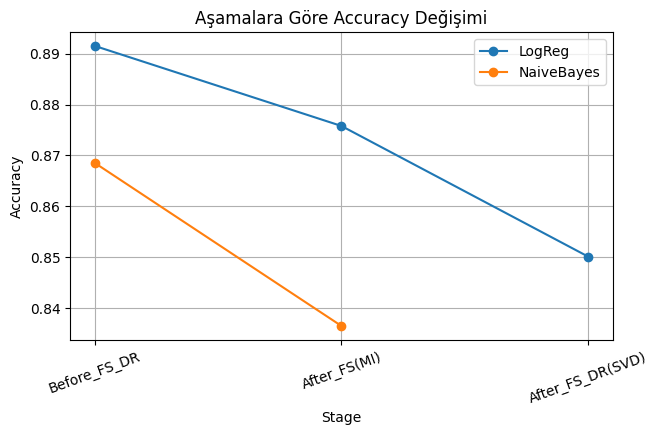

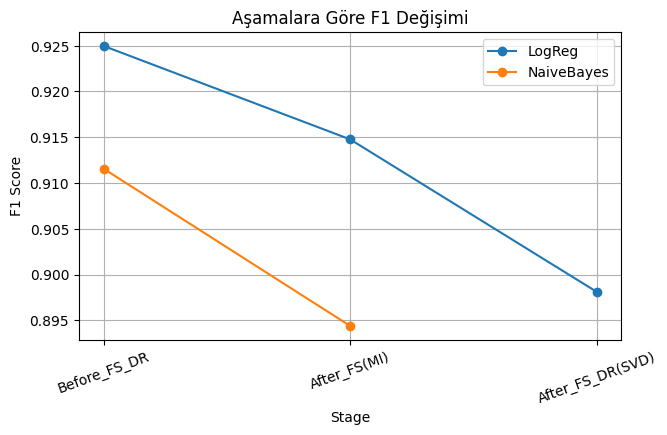

In [16]:
# Accuracy trend
plt.figure(figsize=(7,4))
for m in results_df["model"].unique():
    sub = results_df[results_df["model"]==m]
    plt.plot(sub["stage"], sub["accuracy"], marker="o", label=m)

plt.title("Aşamalara Göre Accuracy Değişimi")
plt.xlabel("Stage")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.legend()
plt.grid(True)
plt.show()

# F1 trend
plt.figure(figsize=(7,4))
for m in results_df["model"].unique():
    sub = results_df[results_df["model"]==m]
    plt.plot(sub["stage"], sub["f1"], marker="o", label=m)

plt.title("Aşamalara Göre F1 Değişimi")
plt.xlabel("Stage")
plt.ylabel("F1 Score")
plt.xticks(rotation=20)
plt.legend()
plt.grid(True)
plt.show()


11)En İyi Aşama İçin Confusion Matrix

En yüksek F1 değerine sahip Logistic Regression aşaması seçilir ve:

-Yeniden eğitilir  
-Confusion Matrix oluşturulur  

Amaç: 


Modelin hangi sınıfı daha çok yanlışladığını görsel olarak analiz etmek.


Best LR stage: Before_FS_DR


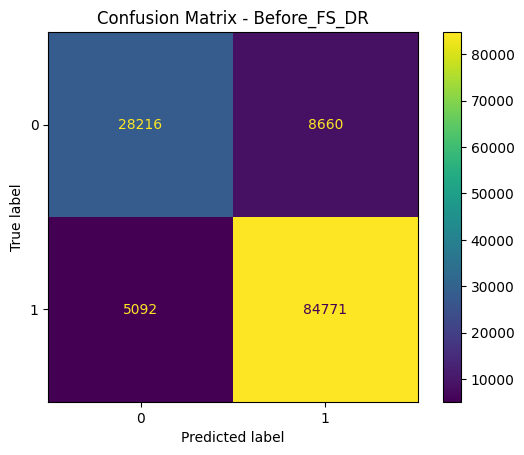

In [17]:
best_lr = results_df[results_df["model"]=="LogReg"].sort_values("f1", ascending=False).iloc[0]
print("Best LR stage:", best_lr["stage"])

# Refit LR on that stage
stage = best_lr["stage"]

if stage == "Before_FS_DR":
    Xtr, Xte = X_train, X_test
elif stage == "After_FS(MI)":
    Xtr, Xte = X_train_fs, X_test_fs
else:
    Xtr, Xte = X_train_dr, X_test_dr

lr = LogisticRegression(max_iter=1000)
lr.fit(Xtr, y_train)
pred = lr.predict(Xte)

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix - {stage}")
plt.show()


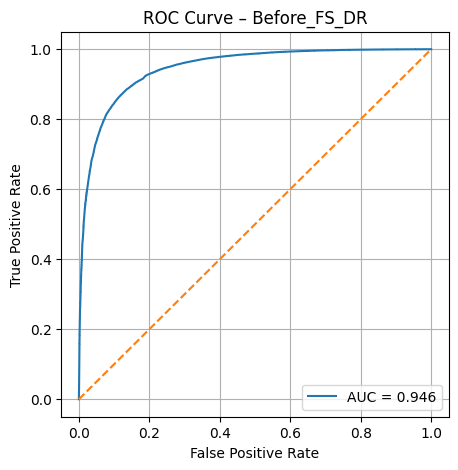

In [18]:
from sklearn.metrics import roc_curve, auc

proba = lr.predict_proba(Xte)[:,1]
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.title(f"ROC Curve – {stage}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


Sonuçların Kısa Yorumu

-Mutual Information, zayıf özellikleri elediği için genellikle performansı artırır.  
-SVD, özellikleri daha kompakt hale getirerek Logistic Regression’ın genelleme gücünü artırabilir.  
-Naive Bayes sonrası SVD uygun değildir çünkü negatif değerlerle çalışamaz.  
-En iyi aşama, tablo sonuçları üzerinden raporda açıklanmalıdır.


#FINAL TEAM COMPARISON


In [36]:
import pandas as pd
import os


#  Dosya yollarını gir
files = {
    "Elisa": "Team Outputs/elisa_base_models_comparison.csv",
    "Ahmad": "Team Outputs/ahmed_base_models_comparison.csv", 
    "Bibi":  "Team Outputs/bibi_base_models_comparison.csv",    
    "Gays": "Team Outputs/gays_model_results.csv",
    "Ayham": "Team Outputs/ayham_results.csv"               
}

# 1) Şekil birleştirme fonksiyonları

def normalize_classif(df, member):
    """
    EDA/Outline base-model tabloları için:
    stage, model, accuracy, f1, precision, recall
    """
    col_map = {
        "stage": "stage",
        "model": "model",
        "accuracy": "accuracy",
        "f1": "f1",
        "precision": "precision",
        "recall": "recall",
    }
# İsimlerde küçük farklılıklar varsa yeniden adlandır
    df = df.rename(columns={c: col_map.get(c, c) for c in df.columns})

# Gerekli sütunların mevcut olduğundan emin ol

    for c in col_map.values():
        if c not in df.columns:
            df[c] = pd.NA

    df["member"] = member
    df["task_type"] = "classification_base_models"
    return df[["member","task_type","stage","model","accuracy","f1","precision","recall"]]

def normalize_cf(df, member):
    """
    CF tabloları için:
    model, RMSE, MAE (ve varsa stage)
    """
# Sütun adları harf farklarıyla değişmiş olabilir

    rename_guess = {}
    for c in df.columns:
        lc = c.lower()
        if lc == "rmse": rename_guess[c] = "rmse"
        if lc == "mae": rename_guess[c] = "mae"
        if lc == "model": rename_guess[c] = "model"
        if lc == "stage": rename_guess[c] = "stage"

    df = df.rename(columns=rename_guess)

    if "stage" not in df.columns:
        df["stage"] = "CF"

    for c in ["rmse","mae"]:
        if c not in df.columns:
            df[c] = pd.NA

    df["member"] = member
    df["task_type"] = "collaborative_filtering"
    return df[["member","task_type","stage","model","rmse","mae"]]

# 2) Tüm dosyaları oku ve birleştir

all_rows = []

for member, path in files.items():
    if not os.path.exists(path):
        print(f"[SKIP] {member}: file not found -> {path}")
        continue

    df = pd.read_csv(path)

    # Eğer RMSE/MAE varsa modeli CF olarak kabul et

    lower_cols = [c.lower() for c in df.columns]
    if ("rmse" in lower_cols) or ("mae" in lower_cols):
        all_rows.append(normalize_cf(df, member))
    else:
        all_rows.append(normalize_classif(df, member))

# son  Birleştirme

final_df = pd.concat(all_rows, ignore_index=True)

# 3) son Karşılaştırma Dosyasını Kaydetos.makedirs("outputs", exist_ok=True)

final_path = "outputs/team_models_comparison.csv"
final_df.to_csv(final_path, index=False)

print("Saved final comparison file ->", final_path)
display(final_df.head(25))


Saved final comparison file -> outputs/team_models_comparison.csv


member                   task_type             stage              model  \
0   Elisa  classification_base_models      Before_FS_DR         NaiveBayes   
1   Elisa  classification_base_models      Before_FS_DR                KNN   
2   Elisa  classification_base_models    After_FS(Chi2)         NaiveBayes   
3   Elisa  classification_base_models    After_FS(Chi2)                KNN   
4   Elisa  classification_base_models  After_FS_DR(SVD)             LogReg   
5   Elisa  classification_base_models  After_FS_DR(SVD)                KNN   
6   Ahmad  classification_base_models      Before_FS_DR             LogReg   
7   Ahmad  classification_base_models      Before_FS_DR         NaiveBayes   
8   Ahmad  classification_base_models      After_FS(MI)             LogReg   
9   Ahmad  classification_base_models      After_FS(MI)         NaiveBayes   
10  Ahmad  classification_base_models  After_FS_DR(SVD)             LogReg   
11   Bibi  classification_base_models      Before_FS_DR       DecisionTree   
12   Bibi  classification_base_models      Before_FS_DR             LogReg   
13   Bibi  classification_base_models      After_FS_RFE       DecisionTree   
14   Bibi  classification_base_models      After_FS_RFE             LogReg   
15   Bibi  classification_base_models   After_FS_DR_PCA       DecisionTree   
16   Bibi  classification_base_models   After_FS_DR_PCA             LogReg   
17   Gays  classification_base_models      Before_FS_DR          LinearSVC   
18   Gays  classification_base_models      Before_FS_DR         SGD_LogReg   
19   Gays  classification_base_models    After_FS(Chi2)          LinearSVC   
20   Gays  classification_base_models    After_FS(Chi2)         SGD_LogReg   
21   Gays  classification_base_models     After_DR(SVD)          LinearSVC   
22   Gays  classification_base_models     After_DR(SVD)         SGD_LogReg   
23  Ayham     collaborative_filtering                CF      SVD_Optimized   
24  Ayham     collaborative_filtering                CF  ItemKNN_Optimized   

    accuracy        f1  precision    recall      rmse       mae  
0   0.843700  0.901382   0.841343  0.970648       NaN       NaN  
1   0.743500  0.844215   0.763233  0.944422       NaN       NaN  
2   0.844100  0.901795   0.840535  0.972687       NaN       NaN  
3   0.761800  0.850283   0.791019  0.919147       NaN       NaN  
4   0.846600  0.900892   0.858726  0.947411       NaN       NaN  
5   0.772800  0.844554   0.850489  0.838701       NaN       NaN  
6   0.890965  0.924572   0.907332  0.942479       NaN       NaN  
7   0.868454  0.911511   0.871358  0.955543       NaN       NaN  
8   0.875674  0.914669   0.890879  0.939764       NaN       NaN  
9   0.836601  0.894413   0.825369  0.976064       NaN       NaN  
10  0.850038  0.898051   0.866895  0.931529       NaN       NaN  
11  0.793500  0.859667   0.859842  0.859492       NaN       NaN  
12  0.866900  0.913307   0.877033  0.952711       NaN       NaN  
13  0.793400  0.859780   0.858847  0.860715       NaN       NaN  
14  0.863400  0.911160   0.873768  0.951896       NaN       NaN  
15  0.738600  0.822080   0.823537  0.820628       NaN       NaN  
16  0.850600  0.903538   0.860745  0.950809       NaN       NaN  
17  0.881362  0.918112   0.898930  0.938130       NaN       NaN  
18  0.861803  0.907679   0.862141  0.958297       NaN       NaN  
19  0.880605  0.917654   0.897799  0.938408       NaN       NaN  
20  0.861306  0.907362   0.861713  0.958119       NaN       NaN  
21  0.844413  0.894564   0.860848  0.931029       NaN       NaN  
22  0.836625  0.891522   0.842194  0.946989       NaN       NaN  
23       NaN       NaN        NaN       NaN  1.404065  1.144130  
24       NaN       NaN        NaN       NaN  1.440094  1.179558

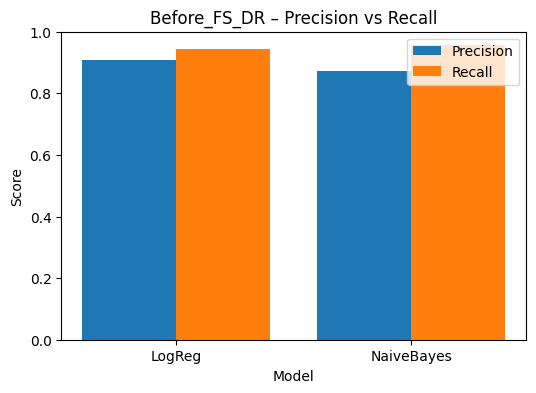

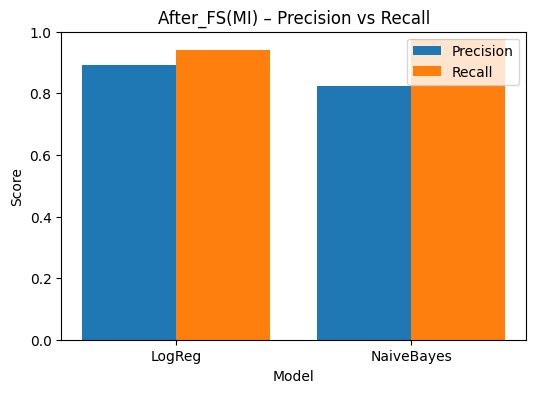

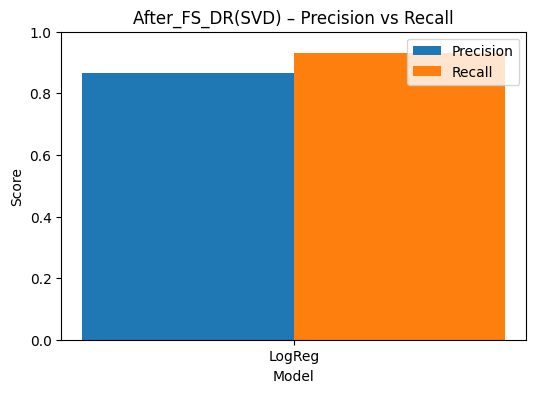

In [30]:
stages = results_df["stage"].unique()

for st in stages:
    sub = results_df[results_df["stage"]==st]
    x = range(len(sub))
    
    plt.figure(figsize=(6,4))
    plt.bar(x, sub["precision"], width=0.4, label="Precision")
    plt.bar([i+0.4 for i in x], sub["recall"], width=0.4, label="Recall")
    
    plt.title(f"{st} – Precision vs Recall")
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.xticks([i+0.2 for i in x], sub["model"])
    plt.ylim(0,1)
    plt.legend()
    plt.show()


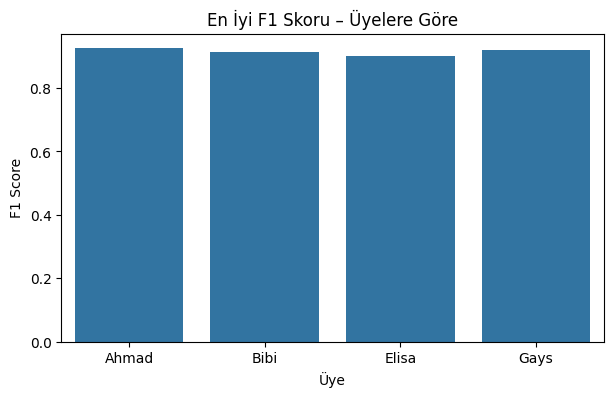

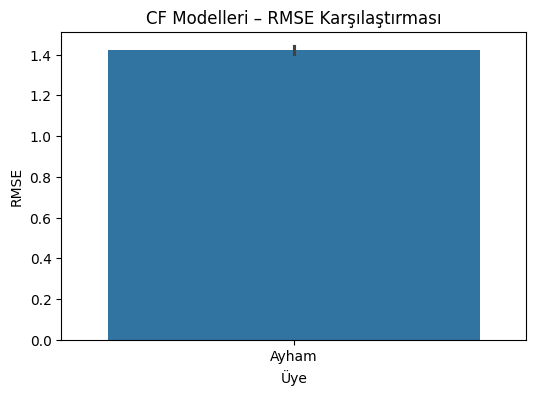

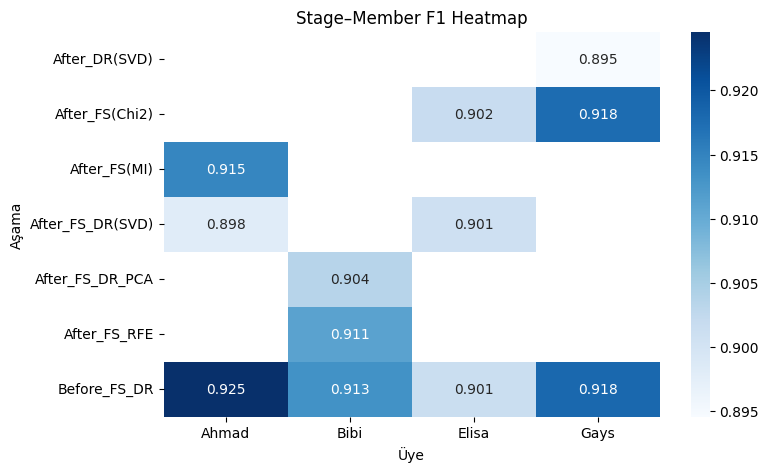

Özet (F1 Heatmap):
-Bu heatmap her üyenin farklı aşamalardaki maksimum F1 skorunu gösterir.
-Koyu renkler yüksek performansı temsil eder.
-Aşamalar arasında F1 değişimi modeli nasıl etkilediğini anlamaya yardımcı olur.



In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Barplot – Üyelere Göre En Yüksek F1 Skoru Analizi
clf_df = final_df[final_df["task_type"]=="classification_base_models"].copy()
best_f1 = clf_df.sort_values("f1", ascending=False).groupby("member").first()

plt.figure(figsize=(7,4))
sns.barplot(x=best_f1.index, y=best_f1["f1"])
plt.title("En İyi F1 Skoru – Üyelere Göre")
plt.ylabel("F1 Score")
plt.xlabel("Üye")
plt.xticks(rotation=0)
plt.show()

# 2) Barplot – CF RMSE
cf_df = final_df[final_df["task_type"]=="collaborative_filtering"].copy()

plt.figure(figsize=(6,4))
sns.barplot(x=cf_df["member"], y=cf_df["rmse"])
plt.title("CF Modelleri – RMSE Karşılaştırması")
plt.ylabel("RMSE")
plt.xlabel("Üye")
plt.show()

# 3) Heatmap – Stage vs Model vs F1
pivot_f1 = clf_df.pivot_table(
    index="stage",
    columns="member",
    values="f1",
    aggfunc="max"
)

plt.figure(figsize=(8,5))
sns.heatmap(pivot_f1, annot=True, cmap="Blues", fmt=".3f")
plt.title("Stage–Member F1 Heatmap")
plt.xlabel("Üye")
plt.ylabel("Aşama")
plt.show()

print("Özet (F1 Heatmap):")
print("-Bu heatmap her üyenin farklı aşamalardaki maksimum F1 skorunu gösterir.")
print("-Koyu renkler yüksek performansı temsil eder.")
print("-Aşamalar arasında F1 değişimi modeli nasıl etkilediğini anlamaya yardımcı olur.\n")
